<a href="https://colab.research.google.com/github/oromiaGodanna/Brain-Imaging_2022_VU/blob/main/Copy_of_nuisances.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Like in the previous notebook, we'll use example data for this notebook. The notebook assumes it's stored in a folder next to the notebook called `data`. You can download these data from Canvas (in which case you'll have to unzip it in the `data` folder), or the course GitHub page. 

When you upload these data to CoLab, make sure that you're pointing the data in the right direction. If you've saved the data to your `Colab Notebooks/data` folder, that is the following location: `/content/drive/My Drive/Colab Notebooks/data/`. The code below tries to set it up so that you don't need to worry about it.

In [3]:
# this will ask you to authenticate with Google
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/')

## we'll also have to install the library to access nifti files:
!pip install nibabel

Mounted at /content/drive


# Neuroimaging week 4: Preprocessing
This week's lab is about preprocessing of fMRI data. Preprocessing of (f)MRI data is quite a complex topic, involving techniques from signal-processing (high-pass filtering), linear algebra/statistics (prewhitening/autocorrelation correction), and optimization (image registration). Additionally, there is ongoing discussion about which preprocessing steps are necessary/sufficient and what preprocessing parameters are optimal. As always, this depends on your specific research question, the type and quality of your data, and the type of analysis.

In this week, we'll discuss a couple (not all!) of preprocessing steps that are common in univariate fMRI analyses. We won't discuss distortion-correction ("unwarping") and registration procedures; please use the videos, the book, and the lecture slides to understand these concepts.

### Contents
1. Introduction: the t-value (yet again)
2. Temporal filtering
3. Prewhitening/autocorrelation correction
4. Spatial filtering
5. Outlier censoring
6. Motion correction and motion filtering

### What you'll learn
Specifically, after this lab, you'll ...

- be able to explain the influence of preprocessing on the measured effects using the t-value formula
- understand (the advantage of) temporal filtering from both the time-domain and frequency-domain
- understand the necessity of prewhitening given the assumptions of the GLM
- understand the advantage of spatial filtering (smoothing)
- under how to handle outliers
- explain the necessity of motion correction and the advantage of motion regression
- know how to implement the concepts above in Python

**Estimated time needed to complete**: 8 hours<br>
**No Deadline**

## 1. Introduction
As we said before, preprocessing is a topic that almost warrants its own course. Nonetheless, we'll try to show you (and let you practice with) some of the most common and important preprocessing operations. Additionally, we'll introduce the concept of the fast fourier transform, which allows us to analyze our signal in the frequency domain, which helps to understand several preprocessing steps, such as temporal filtering.

### 1.1. The (conceptual) t-value formula -- yet again
The previous two weeks, you have learned that, essentially, we want to find large effects (calculated as t-values) of our contrasts by optimizing various parts of the t-value formula. Conceptually, the t-value formula can be written as:

\begin{align}
t\mathrm{-value} = \frac{\mathrm{effect}}{\mathrm{uncertainty}} = \frac{\mathrm{effect}}{\sqrt{\mathrm{noise} \cdot \mathrm{design\ variance}}} = \frac{\mathbf{c}\hat{\beta}}{\sqrt{\hat{\sigma}^{2}\mathbf{c}(X'X')^{-1}\mathbf{c}'}}
\end{align}

Last week you've learned that by ensuring low design variance (through *high* predictor variance and *low* predictor correlations) leads to larger normalized effects (higher t-values). This week, we will discuss the other term of the denominator of this formula: the noise (also called the residual variance or unexplained variance), which is defined in the t-value formula as follows:

\begin{align}
\mathrm{noise} = \frac{SSE}{\mathrm{DF}} = \frac{\sum_{i=1}^{N}(y_{i} - \hat{y_{i}})^{2}}{N - P}
\end{align}

Through preprocessing, we aim to reduce the difference between our prediction ($\hat{y}$) and our true signal ($y$), thus reducing the noise-term of the formula and thereby optimizing our normalized effects.

### 1.2. The two approaches of preprocessing

Basically, there are *two* ways to preprocess your data:
1. Manipulating the signal ($y$) **directly** *before* fitting your GLM-model;
2. Including "noise predictors" in your design ($X$) when fitting your model;

Often, preprocessing steps can be done both by method 1 (manipulating the signal directly) and by method 2 (including noise predictors). For example, one of the videos showed that you could apply a high-pass filter by applying a "gaussian weighted running line smoother" (the method FSL employs) *directly* on the signal (method 1) **or** you could add "low-frequency (drift) predictors" to the design matrix (method 2; in the video they used a 'discrete cosine basis set'; the SPM method). In practice, both methods often yield very similar resuls. The most important thing to understand is that both methods are trying to accomplish the same goal: reduce the noise term of the model.

First, we will discuss how temporal and spatial filtering can *directly* filter the signal (method 1) to reduce error. Later in the tutorial, we will discuss including adding outlier-predictors and motion-predictors to the design to reduce noise (method 2). 

## 2. Temporal filtering
In this section, we will discuss how temporal filtering of the voxel signals may greatly reduce the error term. Along the way, we will also explain how we can look at the representation of the signal in the frequency domain (using the fourier transform) to give us an idea about the nature of the noise components in our data.

### 2.1. A short primer on the frequency domain and the fourier transform
Thus far, we've always looked at our fMRI-signal as activity that varies across **time**. In other words, we're always looking at the signal in the *time domain*. However, there is also a way to look at a signal in the *frequency domain* (also called 'spectral domain') through transforming the signal using the *Fourier transform*. 

Basically, the fourier transform calculates to which degree sine waves of different frequencies are present in your signal. If a sine wave of a certain frequency (let's say 2 hertz) is (relatively) strongly present in your signal, it will have a (relatively) high *power* in the frequency domain. Thus, looking at the frequency domain of a signal can tell you something about the frequencies of the (different) sources underlying your signal.

This may sound quite abstract, so let's look at some examples.

In [4]:
# start with importing the python packages we'll need 
import numpy as np
from numpy.linalg import lstsq
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline 

def double_gamma(x, lag=6, a2=12, b1=0.9, b2=0.9, c=0.35, scale=True):

    a1 = lag
    d1 = a1 * b1 
    d2 = a2 * b2 
    hrf = np.array([(t/(d1))**a1 * np.exp(-(t-d1)/b1) - c*(t/(d2))**a2 * np.exp(-(t-d2)/b2) for t in x])
    
    if scale:
        hrf = (1 - hrf.min()) * (hrf - hrf.min()) / (hrf.max() - hrf.min()) + hrf.min()
    return hrf

def create_sine_wave(timepoints, frequency=1,amplitude=1, phase=0):
    return amplitude * np.sin(2*np.pi*frequency*timepoints + phase)

Sine waves are oscillating signals that have (for our purposes) two important characteristics: their *frequency* and their *amplitude*. Frequency reflects how fast a signal is oscillating (how many cycles it completes in a given time period) and the amplitude is the (absolute) height of the peaks and troughs of the signal. To illustrate this, we generate a couple of sine-waves (with a sampling rate of 500 Hz, i.e., 500 samples per second) with different amplitudes and frequencies, which we plot below:

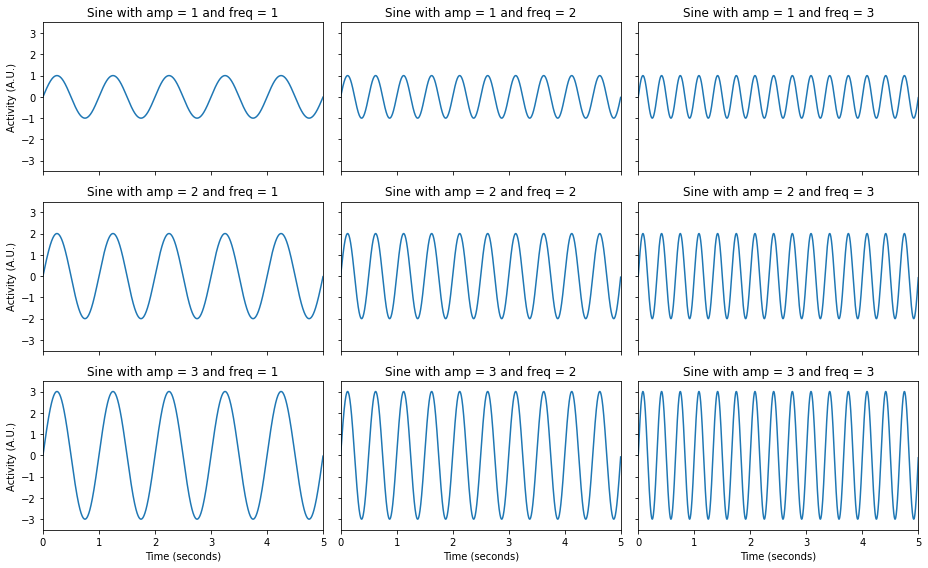

In [5]:
max_time = 5
sampling_rate = 500
timepoints = np.arange(0, max_time, 1.0 / sampling_rate)

amplitudes = np.arange(1, 4)
frequencies = np.arange(1, 4)
sines = []

fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(13, 8))
for i, amp in enumerate(amplitudes):
    
    for ii, freq in enumerate(frequencies):
        this_ax = axes[i, ii]
        
        if ii == 0:
            this_ax.set_ylabel('Activity (A.U.)')
        
        if i == 2:
            this_ax.set_xlabel('Time (seconds)')
        
        sine = create_sine_wave(timepoints, frequency=freq, amplitude=amp)    
        sines.append((sine, amp, freq))
        this_ax.plot(timepoints, sine)
        this_ax.set_xlim(0, 5)
        this_ax.set_title('Sine with amp = %i and freq = %i' % (amp, freq))
        this_ax.set_ylim(-3.5, 3.5)

fig.tight_layout()

As you can see, the signals vary in their amplitude (from 1 to 3) and their frequency (from 1 - 3). Make sure you understand these characteristics! Now, we are going to use the fast fourier transform to plot the same signals in the *frequency domain*. We're not going to use a function to compute the FFT-transformation, but we're going to use a function that computes the "power spectrum density" directly (which makes life a little bit easier): the `periodogram` function from `scipy.signal`:

In [6]:
from scipy.signal import periodogram

Now, the `periodogram` function takes two arguments, the signal and the sampling frequency (the sampling rate in Hz with which you recorded the signal), and returns both the reconstructed frequencies and their associated power values. An example:

```python
freqs, power = periodogram(some_signal, 1000)  # sampling_rate = 1000 Hz
```

We'll use the `periodogram` function to plot the 9 sine-waves (from the previous plot) again, but this time in the frequency domain:

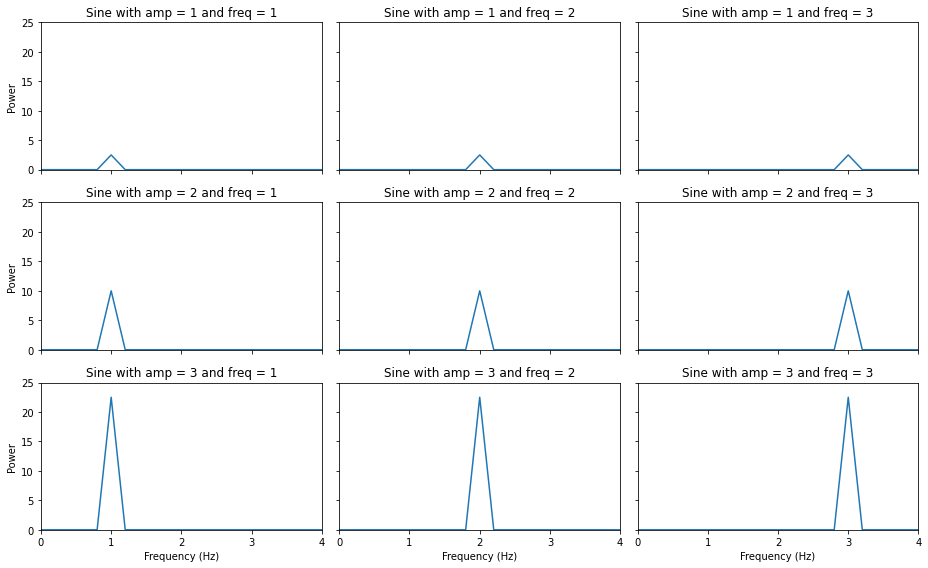

In [7]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(13, 8))

for i, ax in enumerate(axes.flatten()):
    sine, amp, freq = sines[i]
    title = 'Sine with amp = %i and freq = %i' % (amp, freq)
    freq, power = periodogram(sine, sampling_rate)
    ax.plot(freq, power)
    ax.set_xlim(0, 4)
    ax.set_xticks(np.arange(5))
    ax.set_ylim(0, 25)
    
    if i > 5:
        ax.set_xlabel('Frequency (Hz)')
    
    if i % 3 == 0:
        ax.set_ylabel('Power')
    ax.set_title(title)
    
fig.tight_layout()

As you can see, the frequency domain correctly 'identifies' the amplitudes and frequencies from the signals. But the real 'power' from fourier transforms is that they can reconstruct a signal in *multiple underlying oscillatory sources*. Let's see how that works. We're going to load in a time-series recorded for 5 seconds of which we don't know the underlying oscillatory sources. First, we'll plot the signal in the time-domain:

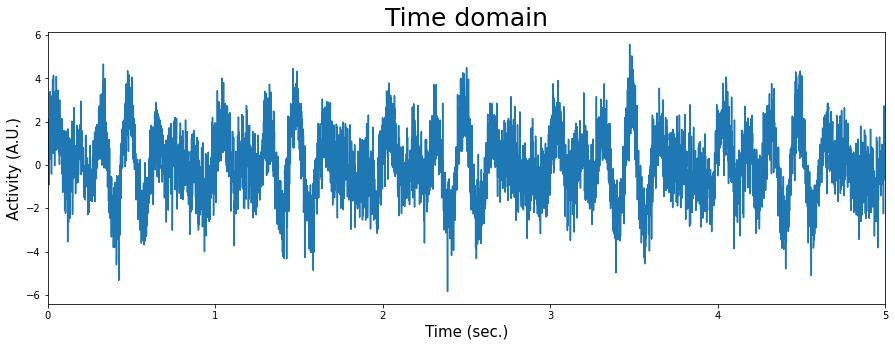

In [8]:
mystery_signal = np.load('data/mystery_signal.npy')
plt.figure(figsize=(15, 5))
plt.plot(np.arange(0, 5, 0.001), mystery_signal)
plt.title('Time domain', fontsize=25)
plt.xlim(0, 5)
plt.xlabel('Time (sec.)', fontsize=15)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.show()

<div class='alert alert-warning'>
<b>ToDo</b> 
</div>

It's hard to see which frequencies (and corresponding amplitudes) are present in this 'mystery signal'. Get the frequencies and power of the signal using the `periodogram` function (you have to deduce the sampling rate of the signal yourself! It is *not* the variable `sampling_rate` from before). Set the x-limit of the x-axis to (0, 8) (`plt.xlim(0, 8)`). Also, give the plot appropriate labels for the axes.

Text(0.5, 0, 'Frequency (Hz)')

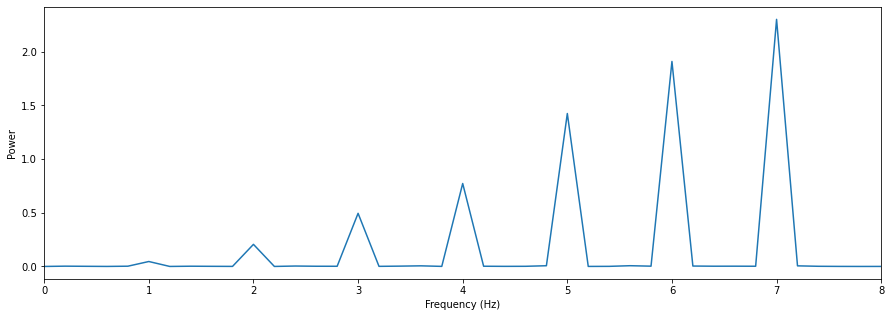

In [9]:
freqs, pows = periodogram(mystery_signal, fs=mystery_signal.size / 5)
plt.figure(figsize=(15, 5))
plt.plot(freqs, pows)
plt.xlim(0, 8)
plt.ylabel('Power')
plt.xlabel('Frequency (Hz)')

Now you know that you can use visualization of the signal in the frequency domain to help you understand from which underlying frequencies your signal is built up. Unfortunately, real fMRI data is not so 'clean' as the simulated sine waves we have used here, but the frequency representation of the fMRI signal can still tell us a lot about the nature and contributions of different (noise- and signal-related) sources!

### 2.2. Frequency characteristics of fMRI data
Now, we will load a (much noisier) voxel signal and the corresponding design-matrix (which has just one predictor apart from the intercept). The signal was measured with a TR of 2 seconds and contains 200 volumes (timepoints). The predictor reflects an experiment in which we showed 20 stimuli in intervals of 20 seconds (i.e., one stimulus every 20 seconds).

We'll plot both the signal ($y$) and the design-matrix ($X$; without intercept):

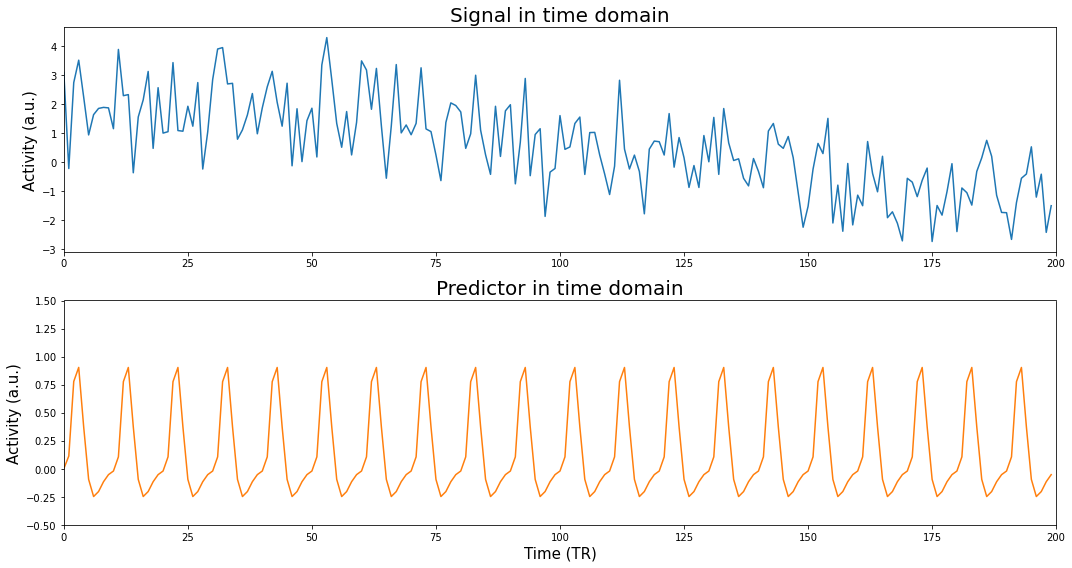

In [10]:
with np.load('data/drift_data.npz') as data:
    X, sig = data['X'], data['sig']
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(sig)
plt.xlim(0, 200)
plt.title('Signal in time domain', fontsize=20)
plt.ylabel('Activity (a.u.)', fontsize=15)

plt.subplot(2, 1, 2)
plt.plot(np.arange(sig.size), X[:, 1], c='tab:orange')
plt.title('Predictor in time domain', fontsize=20)
plt.xlabel('Time (TR)', fontsize=15)
plt.xlim(0, 200)
plt.ylabel('Activity (a.u.)', fontsize=15)
plt.ylim(-0.5, 1.5)
plt.tight_layout()


<div class='alert alert-warning'>
<b>ToDo</b> (2 points)
</div>

Run linear regression using the variable `X` (which already contains an intercept) to explain the variable `sig`. Calculate the model's MSE, and store this in a variable named `mse_no_filtering`. Then, in the next code-cell, plot the signal and the predicted signal ($\hat{y}$) in a single figure. Give the axes sensible labels and add a legend.

**Tip** (feel free to ignore): This tutorial, you'll be asked to compute t-values, R-squared, and MSE of several models quite some times. To make your life easier, you could (but certainly don't have to!) write a function that runs, for example, linear regression and returns the R-squared, given a design (X) and signal (y). For example, this function could look like:

```python
def compute_mse(X, y):
    # you implement the code here (run lstsq, calculate yhat, etc.)
    ...
    # and finally, after you've computed the model's MSE, return it
    return r_squared
```

If you're ambitious, you can even write a single function that calculates t-values, MSE, and R-squared. This could look something like this:

```python
def compute_all_statistics(X, y, cvec):
    # Implement everything you want to know and return it
    ...
    return t_value, MSE, r_squared # and whatever else you've computed!
```

Doing this will save you a lot of time and may prevent you from making unneccesary mistakes (like overwriting variables, typos, etc.). Lazy programmers are the best programmers!

(Note: writing these functions is *optional*!)

In [11]:
def design_variance(X, which_predictor=1):
    ''' Returns the design variance of a predictor (or contrast) in X.
    
    Parameters
    ----------
    X : numpy array
        Array of shape (N, P)
    which_predictor : int or list/array
        The index of the predictor you want the design var from.
        Note that 0 refers to the intercept!
        Alternatively, "which_predictor" can be a contrast-vector
        (which will be discussed later this lab).
        
    Returns
    -------
    des_var : float
        Design variance of the specified predictor/contrast from X.
    '''
    
    is_single = isinstance(which_predictor, int)
    if is_single:
        idx = which_predictor
    else:
        idx = np.array(which_predictor) != 0
    
    c = np.zeros(X.shape[1])
    c[idx] = 1 if is_single == 1 else which_predictor[idx]
    des_var = c.dot(np.linalg.pinv(X.T.dot(X))).dot(c.T)
    return des_var

def compute_all_statistics(X, y, cvec):
    # Implement everything you want to know and return it
    beta_ = np.linalg.lstsq(X, y, rcond=None)[0]
    yhat = X.dot(beta_)
    MSE = np.mean((yhat - y) ** 2)
    r_squared = 1 -  (np.sum((y - yhat) ** 2) / np.sum((y - y.mean()) ** 2))

    
    N = y.size
    P = X.shape[1]
    df = (N - P)
    print("Degrees of freedom: %i" % df)
    sigma_hat = np.sum((y - yhat) ** 2) / df
    print("Sigma-hat (noise) is: %.3f" % sigma_hat)
    des_var = cvec.dot(np.linalg.pinv(X.T.dot(X))).dot(cvec.T)
    t_value = beta_.dot(cvec) / np.sqrt(sigma_hat * des_var)
    return t_value, MSE, r_squared, yhat # and whatever else you've computed!





In [12]:
t_no_filtering, mse_no_filtering,rsq_no_filtering, yhat = \
    compute_all_statistics(X=X, y=sig, cvec=np.zeros(X.shape[1]))
assert(np.round(mse_no_filtering, 3) == 2.187)
print(t_no_filtering, mse_no_filtering,rsq_no_filtering)

Degrees of freedom: 198
Sigma-hat (noise) is: 2.209
nan 2.1870915631826247 0.07960720919947628


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


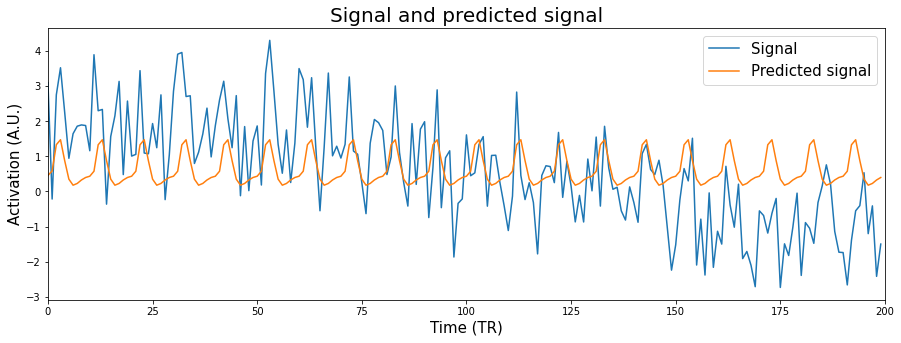

In [13]:
# Implement your y/yhat plot here

plt.figure(figsize=(15, 5))
plt.plot(sig)
plt.plot(yhat)
plt.xlim(0, 200)
plt.title("Signal and predicted signal", fontsize=20)
plt.xlabel("Time (TR)", fontsize=15)
plt.ylabel("Activation (A.U.)", fontsize=15)
plt.legend(['Signal', 'Predicted signal'], fontsize=15)


In [14]:
### From the graph above we can see that our model does not accomodate the unexplained signal which is a 
## slow drift in this case, our regressor does not contain the drift 

<div class='alert alert-info'>
<b>ToThink</b> 
</div>

In your plot above, you should see that the fit of your model is "off" due to some low frequency "drift". Name two potential causes of drift.  

1. Slowly decreasing homogeneity of the magnetic field (e.g. due to subject movement)
2. Increasing thermal noise (i.e., the scanner warms up)

Note: just "subject movement" or respiration/cardiac signal is *NOT* correct.

### 2.3. High-pass filtering of fMRI data
From the previous ToDo, you probably noticed that the fit of the predictor to the model was not very good. The cause for this is the slow 'drift' - a low-frequency signal - that prevents the model from a good fit. Using a high-pass filter - meaning that you *remove* the low-frequency signals and thus *pass only the high frequencies* - can, for this reason, improve the model fit. But before we go on with actually high-pass filtering the signal, let's take a look at the frequency domain representation of our voxel signal: 

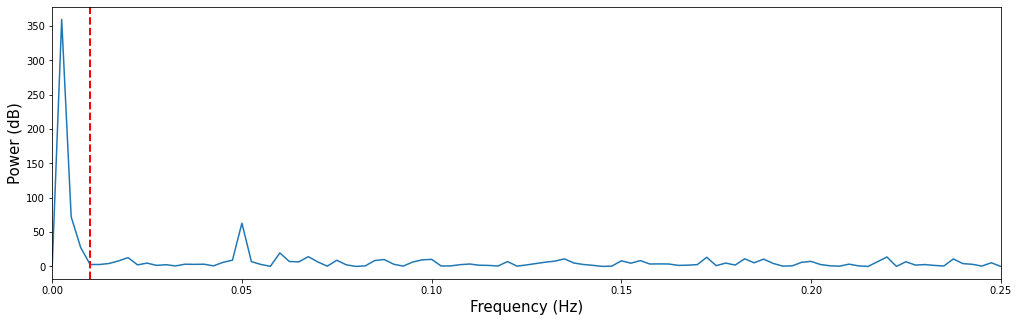

In [15]:
plt.figure(figsize=(17, 5))
TR = 2
sampling_frequency = 1 / TR  # our sampling rate is 0.5, because our TR is 2 sec!
freq, power = periodogram(sig, fs=0.5)
plt.plot(freq, power)
plt.xlim(0, freq.max())
plt.xlabel('Frequency (Hz)', fontsize=15)
plt.ylabel('Power (dB)', fontsize=15)
plt.axvline(x=0.01,color='r',ls='dashed', lw=2)


In the frequency-domain plot above, you can clearly see a low-frequency drift component at frequencies approximately below 0.01 Hz (i.e., left of the dashed red line).

<div class='alert alert-info'>
<b>ToThink</b>
</div>

Apart from the low frequency drift component around 0.01 Hz, there is also a component visible at 0.05 Hz. What does this component represent? Please explain (concisely).

**This reflects our expected response to the stimuli! We presented a stimulus every 20 seconds (10 TRs), which represents a frequency of 0.05!**

Now, let's get rid of that pesky low frequency drift that messes up our model! There is no guideline on how to choose the cutoff of your high-pass filter, but most recommend to use a cutoff of 100 seconds (i.e., of 0.01 Hz). This means that any oscillation slower than 100 seconds (one cycle in 100 seconds) is removed from your signal.

Anyway, as you've seen in the videos, there are many different ways to high-pass your signal (e.g., frequency-based filtering methods vs. time-based filtering methods). Here, we demonstrate a time-based 'gaussian running line smoother', which is used in FSL. As you've seen in the videos, this high-pass filter is estimated by convolving a gaussian "kernel" with the signal (taking the element-wise product and summing the values) across time, which is schematically visualized in the image below:

![](https://docs.google.com/drawings/d/e/2PACX-1vRZTMvXJDBj3HGhrMZxQy1_6T1yF7bVinpBpeIQBgVUPAM_igGXrMonQskFP_Mymy-NVvGJnsvbDhiv/pub?w=934&h=649)

One implementation of this filter is included in the scipy "ndimage" subpackage. Let's import it\*:

---
\***Note**: if you're going to restart your kernel during the lab for whatever reason, make sure to re-import this package to avoid `NameErrors` (i.e., the error that you get when you call a function that isn't imported).

In [16]:
from scipy.ndimage import gaussian_filter

The `gaussian_filter` function takes two mandatory input: some kind of (n-dimensional) signal and a cutoff, "sigma", that refers to the width of the gaussian filter in standard deviations. "What? We decided to define our cutoff in seconds (or, equivalently, Hz), right?", you might think. For some reason neuroimaging packages seem to define cutoff for their temporal filters in **seconds** while more 'low-level' filter implementations (such as in scipy) define cutoffs (of gaussian filters) in **the width of the gaussial filter**, i.e., **sigma**. Fortunately, there is an easy way to (approximately) convert a cutoff in seconds to a cutoff in sigma, given a particular TR (in seconds):

\begin{align}
\sigma \approx \frac{\mathrm{cutoff}_{sec}}{2 \cdot \mathrm{TR}_{sec}}
\end{align}

<div class='alert alert-warning'>
<b>ToDo</b> 
</div>

Suppose I acquire some fMRI data (200 volumes) with a sampling frequency of 0.25 Hz and I would like to apply a high-pass filter of 80 seconds. What sigma should I choose? Calculate sigma and store it in a variable named `sigma_todo`.

In [17]:
sigma_todo = 80/(2 * 4)

np.testing.assert_equal(sigma_todo, 10)


Importantly, the gaussian filter does not return the filtered signal itself, but the estimated low-frequency component of the data. As such, to filter the signal, we have to subtract this low-frequency component from the original signal to get the filtered signal! 

Below, we estimate the low-frequency component using the high-pass filter first and plot it together with the original signal, which shows that it accurately captures the low-frequency drift (upper plot). Then, we subtract the low-frequency component from the original signal to create the filtered signal, and plot it together with the original signal to highlight the effect of filtering (lower plot):

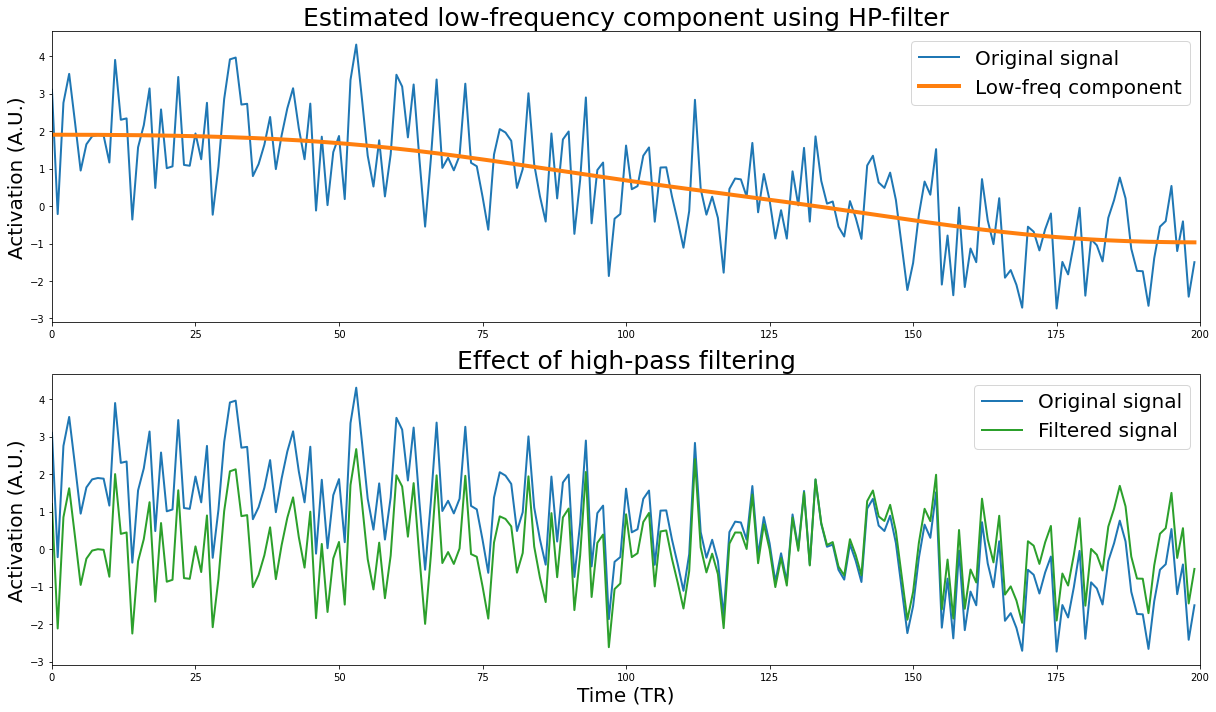

In [18]:
TR = 2.0
sigma_hp = 100 / (2 * TR) 
filt = gaussian_filter(sig, sigma_hp)

plt.figure(figsize=(17, 10))

plt.subplot(2, 1, 1)
plt.plot(sig, lw=2)
plt.plot(filt, lw=4)
plt.xlim(0, 200)
plt.legend(['Original signal', 'Low-freq component'], fontsize=20)
plt.title("Estimated low-frequency component using HP-filter", fontsize=25)
plt.ylabel("Activation (A.U.)", fontsize=20)

filt_sig = sig - filt

plt.subplot(2, 1, 2)
plt.plot(sig, lw=2)
plt.plot(filt_sig, lw=2, c='tab:green')
plt.xlim(0, 200)
plt.legend(['Original signal', 'Filtered signal'], fontsize=20)
plt.title("Effect of high-pass filtering", fontsize=25)
plt.xlabel("Time (TR)", fontsize=20)
plt.ylabel("Activation (A.U.)", fontsize=20)

plt.tight_layout()
plt.show()

The signal looks much better, i.e., it doesn't display much drift anymore. But let's check this by plotting the original and filtered signal in the frequency domain:

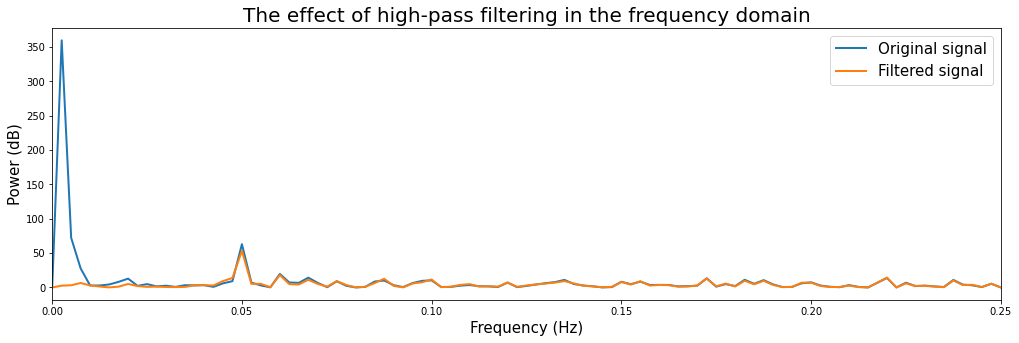

In [19]:
plt.figure(figsize=(17, 5))
freq, power = periodogram(sig, fs=0.5)
plt.plot(freq, power, lw=2)

freq, power = periodogram(filt_sig, fs=0.5)
plt.plot(freq, power, lw=2)
plt.xlim(0, freq.max())
plt.ylabel('Power (dB)', fontsize=15)
plt.xlabel('Frequency (Hz)', fontsize=15)
plt.title("The effect of high-pass filtering in the frequency domain", fontsize=20)
plt.legend(["Original signal", "Filtered signal"], fontsize=15)
plt.show()

Sweet! It seems that the high-pass filtering worked as expected! But does it really improve our model fit?

<div class='alert alert-warning'>
<b>ToDo</b> 
</div>


We've claimed several times that high-pass filtering improves model fit, but is that really the case in our case? To find out, fit the same design (variable `X`) on the filtered signal (variable `filt_sig`) using linear regression. Calculate MSE and store it in the variable `mse_with_filter`.

In [20]:
# your code here, ending in 

t_filtering, mse_with_filter ,rsq_filtering, yhat = \
    compute_all_statistics(X=X, y=filt_sig, cvec=np.zeros(X.shape[1]))

assert(np.round(mse_with_filter, 3) == 0.971)

Degrees of freedom: 198
Sigma-hat (noise) is: 0.981


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


<div class='alert alert-warning'>
<b>ToDo</b> 
</div>

So far, we've filtered only a single (simulated) voxel timeseries. Normally, you want to temporally filter *all* your voxels in your 4D fMRI data, of course. Below, we load in such a 4D fMRI file (`data_4d`), which has $50$ timepoints and ($40 \cdot 40 \cdot 19 = $) $30400$ voxels.

For this ToDo, you need to apply the high-pass filter (i.e., the `gaussian_filter` function; use sigma=25) on each and every voxel separately, which means that you need to loop through all voxels (which amounts to three nested for-loops across all three spatial dimensions). Below, we've already loaded in the data and have written the three nested for-loops. Now it's up to you to filter the signal in the inner-most loop and store it in the pre-allocated `data_4d_filt` variable (the loop may take a couple of seconds!).

There is a test-cell that you can use to test your implementation.

In [21]:
data_4d = nib.load('data/unfiltered_data_ds.nii.gz').get_data()
print("Shape of the original 4D fMRI scan: %s" % (data_4d.shape,))

# Here, we pre-allocate a matrix of the same shape as data_4d, in which
# you need to store the filtered timeseries
data_4d_filt = np.zeros(data_4d.shape)

# Start loop across X-dimension
for i in range(data_4d.shape[0]):

    # Start loop across Y-dimension
    for ii in range(data_4d.shape[1]):
        
        # Start loop across Z-dimension
        for iii in range(data_4d.shape[2]):
            # Filter the timeseries for voxel at location X=i, Y=ii, Z=iii and store it
            # using an appropriate index in the pre-allocated variable data_4d_filt!
            
            # YOUR CODE BEGINS HERE
            filtered_signal = gaussian_filter(data_4d[i, ii, iii, :], sigma=25)
            data_4d_filt[i, ii, iii, :] = data_4d[i, ii, iii, :] - filtered_signal
            # YOUR CODE ENDS HERE

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """Entry point for launching an IPython kernel.


Shape of the original 4D fMRI scan: (40, 40, 19, 50)


In [22]:
np.testing.assert_array_almost_equal(data_4d_filt, np.load('data/answer_filt_4d.npy'))

### 3. Autocorrelation and prewhitening 
As you (should) have seen in the previous ToDo, the model fit increases tremendously after high-pass filtering! This surely is the most important reason why you should apply a high-pass filter. But there is another important reason: high-pass filters reduce the signal's autocorrelation! 

"Sure, but why should we care about autocorrelation?", you might think? Well this has to with the estimation of the standard error of our model, i.e., $\hat{\sigma}^{2}\mathbf{c}(X'X)^{-1}\mathbf{c}'$. As you've seen in the videos, the Gauss-Markov theorem states that in order for OLS to yield valid estimates (including estimates of the parameters' standard errors) *the errors (residuals) have a mean of 0, have 0 covariance (i.e., are uncorrelated), and have equal variance*. 

## Short note about OLS
Ordinary Least Squares regression (OLS) is a common technique for estimating coefficients of linear regression equations which describe the relationship between one or more independent quantitative variables and a dependent variable (simple or multiple linear regression).
Formula
\hat{{\beta}}=\left(\mathbf{X}^{\top} \mathbf{X}\right)^{-1} \mathbf{X}^{\top} \mathbf{y}
\hat \beta	=	ordinary least squares estimator
{X}	=	matrix regressor variable X
\top	=	matrix transpose
{y}	=	vector of the value of the response variable



Let's go through these three assumptions step by step. We'll use the previously filtered signal for this.

#### 3.1. Assumption of zero-mean of the residuals
First, let's check whether the mean of the residuals is zero:

In [23]:
b = np.linalg.lstsq(X, filt_sig, rcond=None)[0]
y_hat = X.dot(b)
resids = filt_sig - y_hat
mean_resids = resids.mean()
print("Mean of residuals: %3.f" % mean_resids)

Mean of residuals:   0


# <div class='alert alert-info'>
<b>ToThink</b>
</div>

What component of the design-matrix ($X$) ensures that the mean of the residuals is zero? Explain (concisely) why.

*The intercept! This predictor makes sure that any constant variance ('offset') is modeled and thus cannot occur in the residuals.*


#### 3.2. Equal variance of the residuals
Alright, sweet - the first assumption seems valid for our data. Now, the next two assumptions -- about equal variance of the residuals and no covariance between residuals -- are trickier to understand and deal with. In the book (and videos), these assumptions are summarized in a single mathemtical statement: the covariance-matrix of the residuals should be equal to the identity-matrix ($\mathbf{I}$) scaled by the noise-term ($\hat{\sigma}^{2}$). Or, put in a formula:

\begin{align}
\mathrm{cov}[\epsilon] = \hat{\sigma}^{2}\mathbf{I}
\end{align}

This sounds difficult, so let's break it down. First off all, the covariance matrix of the residuals is always a symmetric matrix of shape $N \times N$, in which the *diagonal represents the variances* and the *off-diagonal represents the covariances*. For example, at index $[i, i]$, the value represents the variance of the residual at timepoint $i$. At index $[i, j]$, the value represents the covariance between the residuals at timepoints $i$ and $j$. 

In OLS, we assume that the covariance matrix of the residuals ($\mathrm{cov}[\epsilon]$) equals the 
identity-matrix ($\mathbf{I}$) times the noise-term ($\hat{\sigma}^{2}$). The identity-matrix is simply a matrix with all zeros except for the diagonal, which contains ones. For example, the identity-matrix for a residual-array of length $8$ looks like:

In [24]:
identity_mat = np.eye(8)  # makes an 'eye'dentity matrix
print(identity_mat)

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


Now, suppose we calculated that the noise-term of a model explaining this hypothetical signal of length $8$ equals 2.58 ($\hat{\sigma}^{2} = 2.58$). Then, OLS *assumes* the covariance matrix of the residuals equals the identity-matrix times the noise-term:

In [25]:
noise_term = 2.58
assumed_cov_resid = noise_term * identity_mat
print(assumed_cov_resid)

[[2.58 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   2.58 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   2.58 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   2.58 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   2.58 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   2.58 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   2.58 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   2.58]]


In other words, this assumption about the covariance matrix of the residuals states that the *variance across residuals (the diagonal of the matrix) should be equal* and the *covariance between residuals (the off-diagonal values of the matrix) should be 0* (in the population).

Now, we won't explicitly calculate the covariance matrix of the residuals (which is usually estimated using techniques that fall beyond the scope of this course); however, we *do* want you to understand *conceptually* how fMRI data might invalidate the assumptions about the covariance matrix of the residuals and how fMRI analyses deal with this (i.e., using prewhitening, which is explained later). 

So, let's check *visually* whether the assumption of equal variance of our residuals roughly holds for our (simulated) fMRI data. Now, when we consider this assumption in the context of our fMRI data, the assumption of "equal variance of the residuals" (also called homoskedasticity) means that we assume that the "error" in the model is equally big across our timeseries data. In other words, the mis-modelling (error) should be constant over time.

Let's check this for our data:

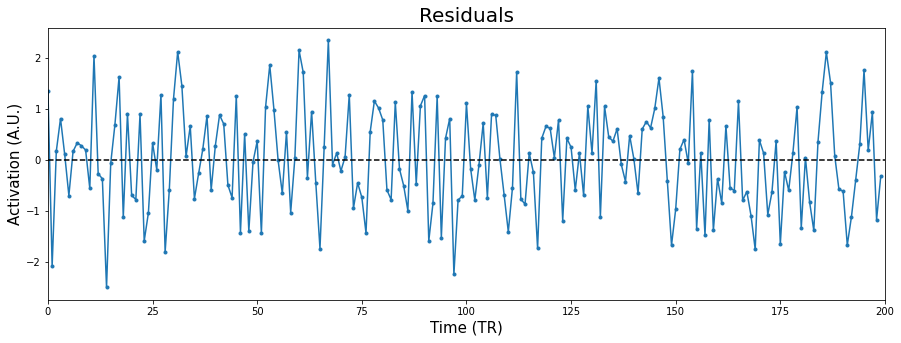

In [26]:
plt.figure(figsize=(15, 5))
plt.plot(resids, marker='.')
plt.xlim(0, 200)
plt.xlabel("Time (TR)", fontsize=15)
plt.ylabel("Activation (A.U.)", fontsize=15)
plt.title("Residuals", fontsize=20)
plt.axhline(0, ls='--', c='black')
plt.show()

<div class='alert alert-info'> 
<b>ToThink</b> 
</div>

What could cause unequal variance in the residuals of an fMRI signal, *given that autocorrelation (i.e. low-frequency components) are filtered out appropriately*? In other words, can you think of something that might cause larger (or smaller) errors across the duration of an fMRI run?


*One reason could be that the noise becomes larger (the signal becomes weaker) due to increasing inhomogeneities of the magnetic field caused by, for example, subject movement. Another cause could be that subjects stop paying attention or do other things that might increase the noise over time. Note: things that cause drift do not necessarily lead to unequal variance across time!*

our assumptions become too liberal when we run these GLM without these three assumptions of independnce. 

We will end up overestimating the effective degrees of freedom in our data and we will use smaller number in our t-statistics.

#### 3.3. Zero covariance between residuals
The last assumption of zero covariance between residuals (corresponding to the assumption of all zeros on the off-diagonal elements of the covariance-matrix of the residuals) basically refers to the assumption that *there is no autocorrelation (correlation in time) in the residuals*. In other words, knowing the residual at timepoint $i$ does not tell you anything about the residual at timepoint $i+1$ (they are *independent*).  

Take for example the residuals of our unfiltered signal from before (I emphasized the drift a little bit more below), which looked like:

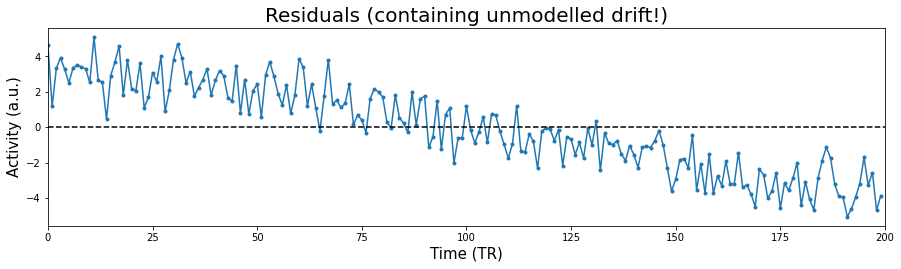

In [27]:
old_sig = sig + np.arange(-2, 2, 0.02)[::-1]
b = np.linalg.lstsq(X, old_sig, rcond=None)[0]
resids_new = old_sig - X.dot(b)

plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(resids_new, marker='.')
plt.axhline(0, ls='--', c='black')
plt.xlim(0, 200)
plt.xlabel("Time (TR)", fontsize=15)
plt.title('Residuals (containing unmodelled drift!)', fontsize=20)
plt.ylabel('Activity (a.u.)', fontsize=15)
plt.show()

In the above plot, reflecting the residuals of a signal in which the drift is obviously not modelled (and is thus contained in the residuals), there is strong autocorrelation: given the slow drift (decreasing values over time) we in fact *do know something about the residual at timepoint $i+1$ given the residual at timepoint $i$, namely that it is likely that the residual at timpoint $i+1$ is __lower__ than the residual at timepoint $i$*! As such, drift is a perfect example of something that (if not modelled) causes autocorrelation in the residuals (i.e. covariance between residuals)! In other words, autocorrelation (e.g. caused by drift) will cause the values of the covariance matrix of the residuals at the indices $[i, i+1]$ to be non-zero, violating the third assumption of Gauss-Markov's theorem!


<div class='alert alert-warning'>
<b>ToDo</b> 
</div>

We stated that autocorrelation captures the information that you have of the residual at timepoint $i+1$ given that you know the residual at timepoint $i$. One way to estimate this ("lag 1") dependence is to calculate the covariance of the residuals with the residuals "shifted" by one "lag". In general, the autocorrelation for the 
residuals $\epsilon$ with lag $\tau$ is calculated as:

\begin{align}
\mathrm{cov}[\epsilon_{i}, \epsilon_{i+\tau}] = \frac{1}{N-\tau-1}\sum_{i=1}^{N-\tau}(\epsilon_{i}\cdot\epsilon_{i+\tau})
\end{align}

Jeanette Mumford explains how to do this quite clearly in her [video on prewhitening](https://www.youtube.com/watch?v=4VSzZKO0k_w) (around minute 10). For this ToDo, calculate the "lag-1" covariance ($\tau = 1$) between the residuals (i.e., using the variable `resids_new`) and store this in a variable named `lag1_cov`.

In [28]:
# your code here:

tau = 1
lag1_cov = resids_new[:-1].dot(resids_new[1:]) / (resids_new.size - tau -1)

In [29]:
# testing your answer
np.testing.assert_almost_equal(lag1_cov, np.load('data/lag1_cov.npy'))

### 3.4. Accounting for autocorrelation: prewhitening
So, in summary, if the covariance matrix of your residuals does not equal the identity-matrix scaled by the noise-term ($\mathrm{cov}[\epsilon] = \hat{\sigma}^{2}\mathbf{I}$), all statistics (beta-parameters, standard errors, t-values, p-values) from the GLM might be biased (usually inflated). 

Unfortunately, even after high-pass filtering (which corrects for *most* but not *all* autocorrelation), the covariance matrix of the residuals of fMRI timeseries usually do no conform to the Markov-Gauss assumptions of equal variance and zero covariance. Fortunately, some methods have been developed by statisticians that transform the data such that the OLS assumptions hold again. One such technique is called *prewhitening*. 

We won't discuss the mathematics of prewhitening, but you have to understand how it works conceptually.

Suppose you have a signal of 20 timepoints (an irrealistically low number, but just ignore that). Now, suppose you have estimated the covariance matrix of the residuals of this signal after modelling (how this covariance-mtarix is calculated is not important for now) - let call this matrix $\mathbf{V}$, which is an $N \times N$ matrix ($N$ referring to the number of timepoints of your signal). Now, suppose you take a look at it and you notice that it looks faaaaar from the identity-matrix ($\mathbf{I}$) that we need for OLS.

For example, you might see this:

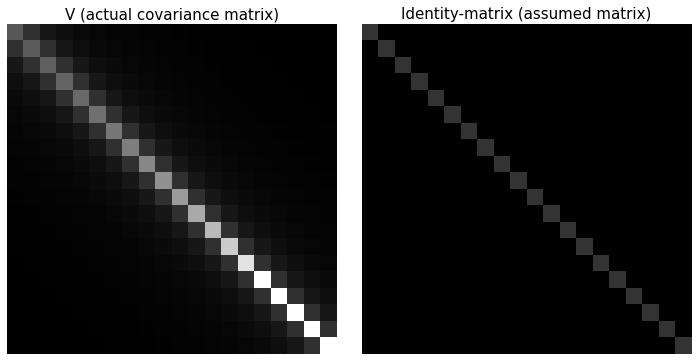

In [30]:
from scipy.linalg import toeplitz

N = 20

# Some magic to create a somewhat realistic covariance matrix
tmp = toeplitz(np.arange(N)).astype(float)
tmp[np.diag_indices_from(tmp)] += np.arange(0.1, 0.6, 0.025)[::-1]

# V represents the covariance matrix
V = 1 / tmp

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(V, vmax=5, cmap='gray')
plt.axis('off')
plt.title("V (actual covariance matrix)", fontsize=15)
plt.subplot(1, 2, 2)
plt.imshow(np.eye(N), vmax=5, cmap='gray')
plt.title("Identity-matrix (assumed matrix)", fontsize=15)
plt.axis('off')
plt.tight_layout()

Well, shit. We have both unequal variance (different values on the diagonal) *and* non-zero covariance (some non-zero values on the off-diagonal). So, what to do now? Well, we can use the technique of prewhitening to make sure our observed covariance matrix ($\mathbf{V}$) will be "converted" to the identity matrix! Basically, this amounts to plugging in some extra terms to formula for ordinary least squares. As you might have seen in the book/videos, the *original* OLS solution (i.e., how OLS finds the beta-parameters is as follows):

\begin{align}
\hat{\beta} = (X'X)^{-1}X'y
\end{align}

Now, given that we've estimated our covariance matrix of the residuals, $\mathbf{V}$, we can rewrite the OLS solution such that it prewhitens the data (and thus the covariance matrix of the residuals will approximate $\hat{\sigma}^{2}\mathbf{I}$) as follows:

\begin{align}
\hat{\beta} = (X'V^{-1}X)^{-1}X'V^{-1}y
\end{align}

Then, accordingly, the standard-error of any contrast of the estimated beta-parameters becomes:

\begin{align}
SE_{\mathbf{c}\hat{\beta}} = \sqrt{\hat{\sigma}^{2} \cdot \mathbf{c}(X'V^{-1}X)^{-1}\mathbf{c}'}
\end{align}

This "modification" of OLS is also called "generalized least squares" (GLS) and is central to univariate fMRI analyses! You *don't* have to understand how this works mathematically; again, you should only understand *why* prewhitening makes sure that our data behaves according to the assumptions of the Gauss-Markov theorem.

(Fortunately for us, there is usually an option to 'turn on' prewhitening in existing software packages, so we don't have to do it ourselves. But it is important to actually turn it on whenever you want to meaningfully and in an unbiased way interpret your statistics in fMRI analyses!)


<div class='alert alert-warning'>
    <b>ToDo</b> (<em>optional!</em>)
</div>

If you want to practice your linear algebra/programming skills, you can (_optionally!_) do this ToDo: given the target signal (`some_sig`), design-matrix (`some_X`), and the (hypothetical) covariance-matrix of the residuals from before (the variable `V`), calculate the beta-parameters using the prewhitened version of OLS (i.e., 'generalized least squares'; the formula above). Also, calculate the t-value of the contrast `[0, 1]` given the appropriate (GLS) computation of the standard-error. Store your results in the variable `betas_gls` and `tval_gls`, respectively.




In [31]:
# Implement your ToDo here!
some_sig = sig[:20]  # y
some_X = X[:20, :]   # X
c_vec = np.array([0, 1])  # the contrast you should use

betas_gls = np.linalg.inv(some_X.T.dot(np.linalg.inv(V)).dot(some_X)).dot(some_X.T).dot(np.linalg.inv(V)).dot(some_sig)
sigma_hat = np.sum((some_sig-some_X.dot(betas_gls))**2)/(some_X.shape[0]-some_X.shape[1])
desvar = c_vec.dot(np.linalg.inv(some_X.T.dot(np.linalg.inv(V)).dot(some_X))).dot(c_vec.T)
tval_gls = c_vec.dot(betas_gls)/np.sqrt(sigma_hat**desvar)


In [33]:
np.testing.assert_array_almost_equal(betas_gls, np.array([1.845, 1.385]), decimal=3)
np.testing.assert_almost_equal(tval_gls, 1.139, decimal=3)

AssertionError: ignored

## 4. Spatial filtering (smoothing)
Alright, so in the previous two sections we've looked at how to filter our signal in the time-domain through high-pass filtering and prewhitening. Importantly, these operations are *performed on the timeseries of each voxel separately* (like you did in a previous ToDo)! Essentially, given our 4D fMRI data ($X \times Y \times Z \times T$), temporal filtering as we discussed here is only applied to the fourth dimension (the time-dimension, $T$).

In addition to temporal filtering, many people also apply a form of *spatial* filtering to their fMRI data, which is thus an operation applied to the *spatial* dimensions ($X$, $Y$, and $Z$) of our 4D data. The most common spatial filtering operation -- spatial smoothing -- is usually implemented using a "3D gaussian (low-pass) smoothing kernel". Sounds familiar? Well, it should, because it's essentially the same type of filter as we used for our temporal high-pass filter! Only this time, it's not a 1-dimensional gaussian ("kernel") that does the high-pass filtering, but it's a 3-dimensional gaussian that does *low-pass* filtering. Just like the temporal gaussian-weighted running line smoother is applied across time, we apply the 3D gaussian across space (i.e., the 3 spatial dimensions, $X$, $Y$, and $Z$). **Note that we don't advocate this at all in modern neuroimaging practice, but understanding the operation is important.**


The figure below schematically visualized the process\*:

![](https://docs.google.com/drawings/d/e/2PACX-1vQZ8Eb8uNU9F0ZLLD1rRNwEE6zab8kVNFsUUZpDcPyDFWrfaPTSNB5otplVAuTV4lR0PhYWM-60_pMD/pub?w=850&h=421)

(Note that we show the spatial data in 2D, simply because it's easier to visualize, but in reality this is always 3D!)

In fact, because both (high-pass) temporal filtering and (low-pass) spatial filtering in most fMRI applications depend on the same "gaussian filtering" principle, we can even use the same Python function: `gaussian_filter`! However, as we mentioned before, spatial smoothing in fMRI is used as a *low-pass filter*, which means that the (spatial!) frequencies *higher* than a certain cutoff are filtered out, while the (spatial!) frequencies *lower* than this cut-off are *passed*. Therefore, we don't need to subtract the output from the `gaussian_filter` function from the (spatial) data! (If we'd would that, than we're effectively high-pass filtering the data!)

---
\* 3D gaussian figure copied from [this website](https://blog.philippklaus.de/2012/10/creating-a-gaussian-window-in-3d-using-matlab).

### 4.1. Smoothing of fMRI data
Before we go on and demonstrate smoothing on fMRI data, we need to determine the sigma of our (3D) gaussian kernel that we'll use to smooth the data. Annoyingly, smoothing kernels in the fMRI literature (and software packages!) are usually not reported in terms of sigma, but as "full-width half maximum" (FWHM), which refers to the width of the gaussian at half the maximum height:

![](http://www.svi.nl/wikiimg/FWHM.png)

For example, you might read in papers something like "We smoothed our data with a gaussian kernel with a FWHM of 3 millimeter". Fortunately, we can easily convert FWHM values to sigmas, using:

\begin{align}
\sigma_{kernel} \approx \frac{\mathrm{FWHM}_{mm}}{2.355 \cdot \mathrm{voxel\ size}_{mm}}
\end{align}

So, for example, if I want to smooth at FWHM = 6 mm and my voxels are 3 mm in size (assuming equal size in the three spatial dimensions, which is common), my sigma becomes:

\begin{align}
\sigma_{kernel} \approx \frac{6}{2.355 \cdot 3} \approx 0.42
\end{align}

The entire conversion process is a bit annoying, but it's simply necessary due to conventions in the fMRI literature/software packages.

Anyway, having dealt with the conversion issue, let's look at an example. We'll use the 4D fMRI data from before (the `data_4d` variable) and we'll extract a single 3D volume which we'll smooth using the `gaussian_filter` function. This particular data has a voxel-size of $6\ mm^{3}$; given that we want to smooth at an FWHM of, let's say, 10 millimeter, we need a sigma of ($\frac{10}{2.355 \cdot 6} \approx $) $0.7$.

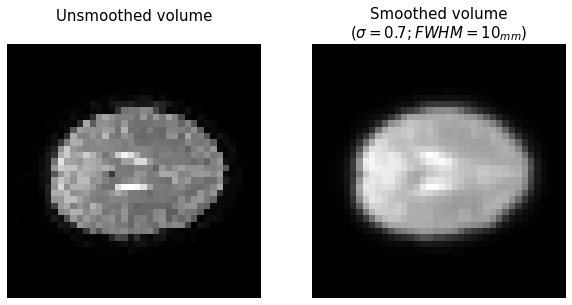

In [34]:
vol = data_4d[:, :, :, 20] # We'll pick the 21st volume (Python is 0-indexed, remember?)

fwhm = 10
voxelsize = 6

sigma = fwhm / (2.355 * voxelsize)
smoothed_vol = gaussian_filter(vol, sigma=sigma)

# Let's plot both the unsmoothed and smoothed volume
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(vol[:, :, 10], cmap='gray') # And we'll pick the 11th axial slice to visualize
plt.axis('off')
plt.title("Unsmoothed volume\n", fontsize=15)

plt.subplot(1, 2, 2)
plt.imshow(smoothed_vol[:, :, 10], cmap='gray')
plt.axis('off')
plt.title('Smoothed volume\n($\sigma = %.1f; FWHM = %s_{mm}$)' % (sigma, fwhm), fontsize=15)
plt.show()

<div class='alert alert-warning'>
<b>ToDo</b> 
</div>

Now, in the above example we only smoothed a single volume, but in your analyses you would of course smooth all volumes in your fMRI run! (Just like with temporal filtering you need to filter the timeseries of all voxels separately.) In this ToDo, you need to loop through all (50) volumes from the `data_4d` variable and smooth them separately. Store the smoothed data in the already pre-allocated variable `data_4d_smoothed`. Use a sigma of 0.7 for the gaussian filter.


In [35]:
# Implement your ToDo here

data_4d_smoothed = np.zeros(data_4d.shape)

for i in range(data_4d.shape[-1]):
    data_4d_smoothed[...,i] = gaussian_filter(data_4d[...,i], sigma=0.7) #data_4d[:,:,:,i]


In [36]:
np.testing.assert_array_almost_equal(data_4d_smoothed, np.load('data/smoothed_data_todo.npy'))

<div class='alert alert-info'>
<b>ToThink</b> 
</div>

Since the `gaussian_filter` works for any $N$-dimensional array, one could argue that you don't have to loop through all volumes and apply a 3D filter, but you could equally well skip the loop and use a 4D filter straightaway. Explain (concisely) why this is a bad idea (for fMRI data).


*This is a bad idea because you have two opposing goals of spatial and temporal filtering: you want to high-pass the temporal dimension while low-pass the spatial dimensions. Applying a single 4D spatial (low-pass) filter will unintentionally also low-pass the temporal dimension.*

## 5. Dealing with outliers
As we've seen, high-pass filtering and spatial smoothing are operations that are applied on the signal directly (before model fitting) to reduce the noise term. Another way to reduce the noise term is to include *noise regressors* (also called 'nuisance variables/regressors') in the design matrix. As such, we can subdivide our design matrix into "predictors of interest" (which are included to model the task/stimuli) and "noise predictors". Or, to reformulate our linear regression equation:

\begin{align}
y = X_{interest}\beta_{interest}  + X_{noise}\beta_{noise} + \epsilon
\end{align}

Importantly, the difference between $X_{noise}$ and $\epsilon$ is that the $X_{noise}$ term refers to noise-related activity that you *are able to model* while the $\epsilon$ term refers to the noise that you *can't model* (this is often called the "irreducible noise/error" term). 

### 5.1. Using noise-predictors for "despiking"
This technique of adding noise-predictors to the design-matrix is sometimes used to model 'gradient artifacts', which are also called 'spikes' (which you've heard about in one of the videos for this week). This technique is also sometimes called "despiking". These spikes reflect sudden large intensity increases in the signal across the entire brain that likely reflect scanner instabilities. One way to deal with these artifacts is to "censor" bad timepoints (containing the spike) in your signal using a noise-predictor.

But what defines a 'spike'/bad timepoint? One way is to average the timeseries across all voxels, generating one single 'global signal' (which makes sense because spikes usually affect measurements across the entire brain), and then apply a z-transform of this global signal, and subsequently identify spikes as any value above a certain threshold. For example, setting this threshold at 5 means that any activity value more than 5 standard deviations from the mean global signal intensity is defined as a spike.

Before explaining how to include these spikes in the design-matrix, let's take a look at the example signal that we're going to use for this section:

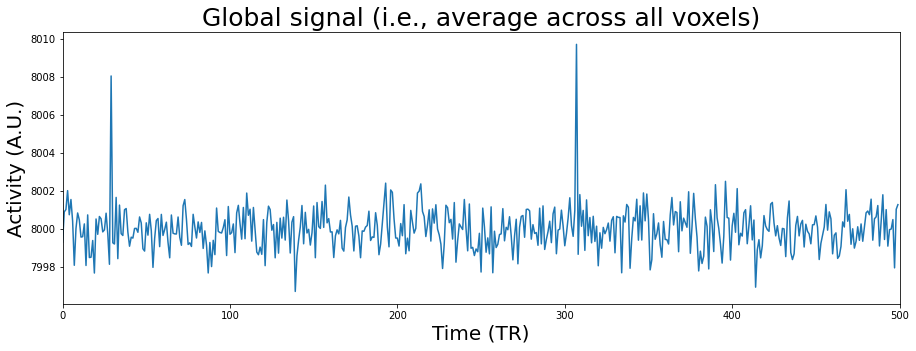

In [37]:
with np.load('data/spike_data.npz') as spike_data:
    global_signal = spike_data['global_signal']
    spike_sig = spike_data['spike_sig']
    pred = spike_data['pred']

plt.figure(figsize=(15, 5))
plt.plot(global_signal)
plt.xlabel("Time (TR)", fontsize=20)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.title("Global signal (i.e., average across all voxels)", fontsize=25)
plt.xlim(0, 500)
plt.show()

As you can see from the plot, there are two apparent 'spikes' in the data (around $t=30$ and $t=300$)!


<div class='alert alert-warning'>
<b>ToDo</b>
</div>

Now, in order to identify spikes, we need to identify timepoints that have an activity-values that differ more than (let's say) 5 standard deviations from the mean activity value. As such, you need to 'z-score' the activity values: subtract the mean value from each individual value and divide each of the resulting 'demeaned' values by the standard deviation ($\mathrm{std}$) of the values. In other words, the z-transform of any signal $s$ with mean $\bar{s}$ is defined as:

\begin{align}
z(s) = \frac{(s - \bar{s})}{\mathrm{std}(s)}
\end{align}

Implement this z-score transform for the variable `global_signal` and store it in the variable `zscored_global_signal`. Then, identify any values above 5 in the `zscored_global_signal` and store these in a variable named `identified_spikes` which thus should contain a numpy array with boolean values in which the timepoints with spikes should be `True` and timepoints without spikes should be `False`. 

(Hint: your `identified_spikes` variable should contain 2 spikes.)

In [38]:
# Implement your ToDo here
zscored_global_signal = (global_signal - global_signal.mean()) / global_signal.std()
identified_spikes = ((global_signal - global_signal.mean()) / global_signal.std() > 5)

In [39]:
np.testing.assert_almost_equal(zscored_global_signal,
                               (global_signal - global_signal.mean()) / global_signal.std())

np.testing.assert_almost_equal(identified_spikes,
                               ((global_signal - global_signal.mean()) / global_signal.std() > 5))


Alright, if you've done the ToDo correctly, you should have found that there are two spikes in the data at timepoints $t = 30$ and $t = 308$. Now, to remove the influence of these spikes, we can include two regressors that model the influence of these timepoints in our design-matrix. These regressors simply contain all zeros except for at the timepoint of the spike, where it contains a 1. Let's create these regressors: 

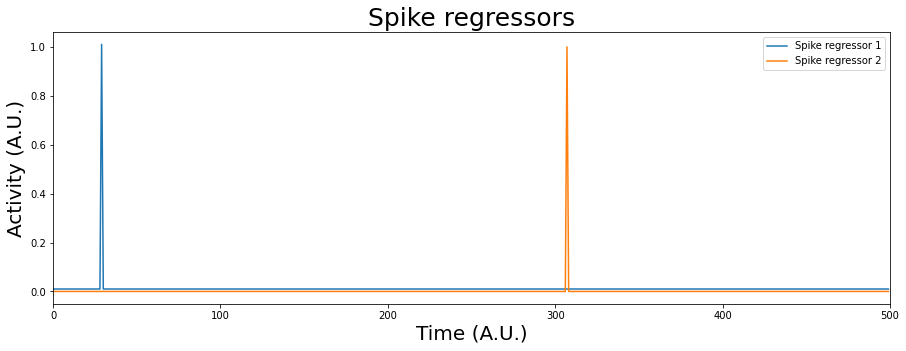

In [40]:
spike_regressor_1 = np.zeros((500, 1))
spike_regressor_1[29] = 1  # remember, Python has 0-based indexing!
spike_regressor_2 = np.zeros((500, 1))
spike_regressor_2[307] = 1

plt.figure(figsize=(15, 5))
plt.plot(spike_regressor_1 + 0.01)  # The 0.01 is for visualization purposes only
plt.plot(spike_regressor_2)
plt.legend(['Spike regressor 1', 'Spike regressor 2'])
plt.xlabel("Time (A.U.)", fontsize=20)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.title("Spike regressors", fontsize=25)
plt.xlim(0, 500)
plt.show()

<div class='alert alert-info'>
    <b>ToThink</b> 
</div>

Why do you think we do not convolve the spike regressors with an HRF (or basis set)? Write your answer in the text-cell below.


*Because spikes are not "activity" related to neural activity! As such, we do not expect a BOLD-response and are thus not incorporating our "hypothesis" of a HRF-shaped response in our model.*

Now, let's plot a signal from a single voxel and the associated (hypothetical) stimulus-predictor.




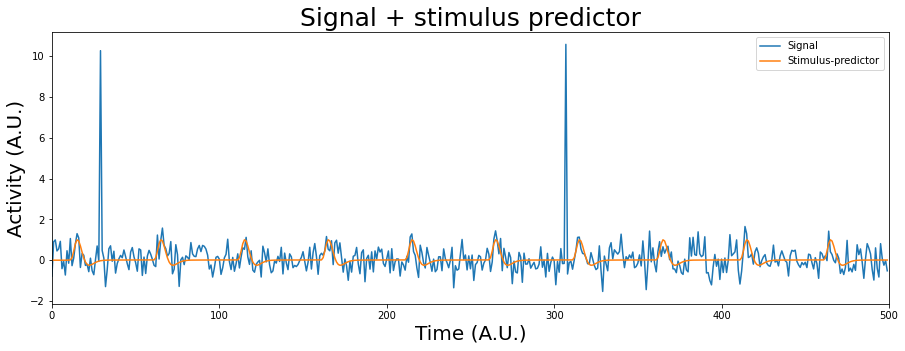

In [41]:
plt.figure(figsize=(15, 5))
plt.plot(spike_sig)
plt.plot(pred)
plt.xlabel("Time (A.U.)", fontsize=20)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.title("Signal + stimulus predictor", fontsize=25)
plt.xlim(0, 500)
plt.legend(['Signal', 'Stimulus-predictor'])
plt.show()

As you can see, the spikes that we found in the global signal are also (as expected) present in the signal of this particular voxel.

<div class='alert alert-warning'>
<b>ToDo</b> 
</div>

Calculate the t-value of the stimulus-predictor-against-baseline contrast in the model with only the stimulus-predictor (don't forget to stack an intercept) and store it in the variable `tval_stimonly` (use `spike_sig` as your target, i.e., $y$). Then, add the two spike-predictors to the design-matrix (use `np.hstack`), which should have 4 columns afterwards (1 intercept, 1 stimulus predictor, 2 spike predictors). Then, calculate the t-value of the stimulus-predictor-against-baseline contrast for the extended model; store the t-value in a variable named `tval_with_spike_preds`.

In [ ]:
# Implement your ToDo here


In [44]:
# test for part one
c = np.array([0, 1])
X_s = np.hstack((np.ones((pred.size, 1)), pred))
b_s = np.linalg.lstsq(X_s, spike_sig, rcond=None)[0]
sigmahat_s = np.sum((spike_sig - X_s.dot(b_s)) ** 2) / (X_s.shape[0] - X_s.shape[1])
desvar_s = c.dot(np.linalg.inv(X_s.T.dot(X_s))).dot(c.T)
answer_stimonly = c.dot(b_s) / np.sqrt(sigmahat_s * desvar_s)
np.testing.assert_almost_equal(answer_stimonly, tval_stimonly, decimal=3)

In [45]:
# test for part two
c = np.array([0, 1, 0, 0])
X_sp = np.hstack((np.ones((pred.size, 1)), pred, spike_regressor_1, spike_regressor_2))
b_sp = np.linalg.lstsq(X_sp, spike_sig, rcond=None)[0]
sigmahat_sp = np.sum((spike_sig - X_sp.dot(b_sp)) ** 2) / (X_sp.shape[0] - X_sp.shape[1])
desvar_sp = c.dot(np.linalg.inv(X_sp.T.dot(X_sp))).dot(c.T)
answer_with_spike_preds = c.dot(b_sp) / np.sqrt(sigmahat_sp * desvar_sp)
np.testing.assert_almost_equal(answer_with_spike_preds, tval_with_spike_preds, decimal=3)

In [46]:
answer_stimonly, answer_with_spike_preds

(5.34903267533716, 9.396088682058801)

If you've done the ToDo correctly, you saw that the t-value from the model with the spike-predictors was much bigger! This is, of course, because the noise term got much smaller (and thus increasing the denominator of the t-value formula).


## 6. Motion preprocessing
This method of preprocessing through including noise predictors, like the spike-predictors in the previous section, is also often used in the context of motion filtering. Basically, in this process you'd like to remove all 'activity' in voxels that are correlated with motion. By including these motion predictors in our model, we make sure that variance in the signal caused my motion is accounted for and does *not* end up in our error term (i.e. the model's residuals/unexplained variance). 

However, these 'motion predictors' do not magically appear, but are a result of a previous step in addressing motion in fMRI. Basically, "motion preprocessing" consists of two parts:

1. Motion correction (realignment);
2. Motion filtering (denoising)

In the first part, the functional image is - volume by volume - realigned such that all volumes are in the same orientation (i.e. the location of each voxel is constant over time). This realignment is done by translating (in three directions) and rotating (in three directions) each volume to match a 'reference volume' (usually the first or middle volume of each file). 

Then, in a second step, we use those 'realignment parameters' (i.e. how much each subject moved over time) in our design matrix as 'noise predictors' that aim to improve model fit by explaining variance related to movement. Let's take a look at these motion parameters.

Let's take a closer look at both of these operations (motion correction/realignment and filtering/denoising).


### 6.1. Motion realignment
Arguably the largest source of noise/unwanted effects in fMRI data is subject motion. When subjects move in the scanner, the homogeneity of the magnetic field is decreased, voxels are shifted in space from timepoint to timepoint, and spurious (de)activity may occur (during modeling). As such, it is *very* important to deal with motion appropriately. By far the *most important thing* you can do to reduce the effect of motion is simply to try to make the subject move as little as possible!

But even if you have a subject that lies as still as possible in the scanner, some subject motion is unavoidable (due to e.g. breathing). As such, you always want to do motion realignment. This process works as follows:

1. Pick a "reference volume" within your fMRI run (e.g. the first or middle volume)
2. For each of the other volumes, try to rotate ("twist" around axes) and translate (move left/right/up/down/forward/backward) such that it matches the reference volume as well as possible

This process of translating and rotating is often called "rigid body transformation", which aims to "register" each volume to the reference volume using 6 parameters: $3$ (translation in $X, Y, Z$ directions) $+\ 3$ (rotation across $X, Y, Z$ axes). 

Fortunately, you don't have to find these 6 parameters yourself for each volume; there are optimization algorithms that do the rotating/translating and matching to the reference volume for you (this type of registration algorithm that we use for motion realignment is similar to the algorithms used for spatial normalization from functional --> T1 --> standard space). These algorithms usually start out with random values for these six parameters, for which they calculate the "mismatch" (also called "cost"; for example in terms of the "correlation distance" between the realigned volume and the reference volume, $1 - \rho(vol, ref\_vol)$). Then, they adjust the parameters such that the "mismatch" decreases. This parameter adjustment is iterated until the "mismatch" is below some threshold.

To get a better intuition of this process, you're actually going to manually do motion realignment in the next ToDo!


<div class='alert alert-warning'>
<b>ToDo</b>
</div>

In this ToDo, you are going to try to manually register two brain images to a reference image using translation (we leave out rotation for the simplicity of the example). For this exercise, we are going to use a 2D brain image (instead of normal 3D volume), simply because it's easier to plot. As such, you can only tweak two parameters: translation in the up/down direction and translation in the left/right direction.

Below, we load in a very short fMRI run with 3 brain images (in 2D), `motion_data`. Then, we provide you with a function that mimicks a motion realigment algorithm, but which you have to tweak yourself manually. We set the reference volume to the middle image (`ref_image=2`). You start out with all the translation parameters set to 0. Run the cell below once to see the initial mismatch between the three volume.

After running the cell below, you should see an image with three brains: the red one represents the reference image (the middle image/second image); the blue one represents the first image and the green one represents the third image (in time). Now, to translate the first image (green) one voxel upwards and the third image (blue) one voxel downwards, set the `translate_up` parameter as follows:

```python
translate_up = [1, -1]
```

Equivalently, if you want to translate the first image (green) two voxels to the left and the second image (blue) three voxels to the right, set the `translate_left` parameter as follows:

```python
translate_left = [2, -3]
```

Try different values for these translation parameters until you you minimize the "mismatch" of the brain images relative to the reference image (i.e., until all three images overlay perfectly)!

In [49]:
from scipy.stats import pearsonr


def translate_volumes(data, ref_image=2, translation_up=None, translation_left=None):
    
    ref_im = data[:, :, (ref_image - 1)]  # assuming data is 3D
    other_ims = np.dstack((data[:, :, :(ref_image -1)],
                           data[:, :, (ref_image):]))
    
    for i, up in enumerate(translation_up):
        other_ims[:, :, i] = np.roll(other_ims[:, :, i], -up, axis=0)
    
    for i, left in enumerate(translation_left):
        other_ims[:, :, i] = np.roll(other_ims[:, :, i], -left, axis=1)
    
    plt.imshow(ref_im, cmap='Reds')
    plt.axis('off')
    
    for i in range(other_ims.shape[-1]):
        
        if other_ims.shape[-1] > 2:
            plt.imshow(other_ims[:, :, i], cmap='Greens', alpha=0.5)
        else:
            if i == 1:
                plt.imshow(other_ims[:, :, i], cmap='Greens', alpha=0.5)
            else:
                plt.imshow(other_ims[:, :, i], cmap='Blues', alpha=0.5)
        plt.axis('off')
        corrdist = 1 - pearsonr(other_ims[:, :, i].ravel(),
                                ref_im.ravel())[0]
        print("Cost (1 - corr) image %i: %.3f" % (i + 1, corrdist))

motion_data = np.load('data/motion_data.npy')

# Tweak the parameters translate_up and translate_left to minimize the mismatches
translate_up = [0, 0]
translate_left = [0, 0]

translate_volumes(motion_data, ref_image=2, translation_up=translate_up, translation_left=translate_left)

translate_up = .....
translate_left = .....

SyntaxError: ignored

In [ ]:
assert(translate_up == [-8, 9])
assert(translate_left == [-5, 3])

### 6.2 Motion filtering
Even after motion realignment, your data is still 'contaminated' by motion. This is because movement itself influences the measured activity. For example, suppose that you measure a single voxel in someone's brain; then, this person moves his/her hea†d 2 centimeters. Now, we can do motion realigment to make sure we measure the same voxel before and after the movement, but *this does not change the fact that this particular voxel was originally measured at two different locations*. It could be that after the movement, the voxel was actually a little bit closer to the headcoil, which results in a (slight) increase in signal compared to before the movement (this is also known as 'spin history effects').

Ideally, you want to account for these interactions between motion and the measured activity. One way to do this is through "motion filtering", of which one popular approach is to simply add the 6 realignment parameters (rotation and translation in 3 directions) to the design-matrix ($X$)! In other words, we treat the motion realignment parameters as "nuisance regressors" that are aimed to explain activity that is related to motion.

Alright, let's load some realigment parameters (6 in total) from an fMRI run of 200 volumes. We'll plot them below:

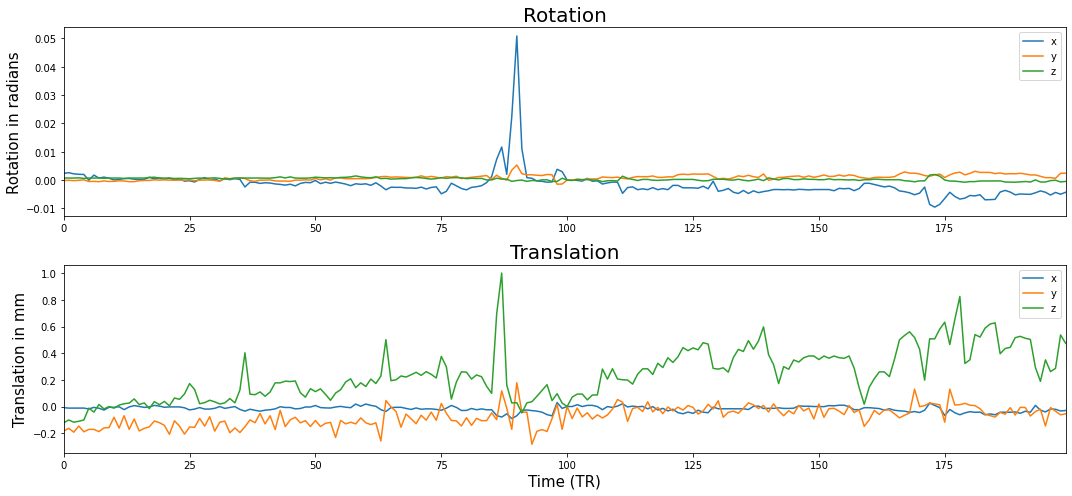

In [67]:
""" This data has been motion-corrected using the FSL tool 'MCFLIRT', which outputs a file
ending in *.par that contains the 6 motion parameters (rotation/translation in 3 directions each).
We'll load in this file and plot these motion parameters. """

motion_params = np.loadtxt('data/mc_unfiltered_data_mcf.par')
rotation_params = motion_params[:, :3]
translation_params = motion_params[:, 3:]

plt.figure(figsize=(15, 7))
plt.subplot(2, 1, 1)
plt.title('Rotation', fontsize=20)
plt.plot(rotation_params)
plt.xlim(0, 199)
plt.legend(['x', 'y', 'z'])
plt.ylabel('Rotation in radians', fontsize=15)

plt.subplot(2, 1, 2)
plt.title('Translation', fontsize=20)
plt.plot(translation_params)
plt.legend(['x', 'y', 'z'])
plt.ylabel('Translation in mm', fontsize=15)
plt.xlim(0, 199)
plt.xlabel('Time (TR)', fontsize=15)
plt.tight_layout()
plt.show()

Looking at the plots, you could say this is pretty good data! Apart from some movement around volume 85 - 90, the participant didn't move a lot. 

<div class='alert alert-info'>
<b>ToThink</b> 
</div>

Looking at the plots above, can you deduce which volume was used as a reference volume? 

<div class='alert alert-warning'>
<b>ToDo</b> 
</div>

For this ToDo, you have to compare two models and the resulting (normalized) effects (t-values): a model *without* the six motion parameters and a model *with* the six motion parameters.

We provide you with a design-matrix (`X`) with an intercept and a single stimulus-predictor and the signal of a single voxel (`sig`). Calculate the t-value for the contrast of the predictor-of-interest against baseline for both the original design-matrix (only intercept + predictor-of-interest) and the design-matrix extended with the six motion parameters (which thus has 8 predictors). To help you a little bit, we broke down this ToDo in multiple steps, each in a different cell.

In [68]:
# First, we'll load the data
with np.load('data/data_last_todo.npz') as data_last_todo:
    X = data_last_todo['X']
    sig = data_last_todo['sig']

print("Shape of original X: %s" % (X.shape,))
print("Shape of signal: %s" % (sig.shape,))

Shape of original X: (200, 2)
Shape of signal: (200,)


Now, in the cell below, calculate the t-value corresponding to the contrast against baseline of our predictor-of-interest. Save this in a variable named `tvalue_simple_model`.

In [69]:
# Calculate the t-value here
tvalue_simple_model, mse, rsq, yhat = compute_all_statistics(X=X, y=sig, cvec=np.array([0,1]))

Degrees of freedom: 198
Sigma-hat (noise) is: 0.246


Then, in the cell below, make a new (extended) design-matrix by stacking the motion parameters (variable `motion_params`) to the original design-matrix (`X`). 

In [70]:
# Create here the extended design matrix with motion parameters (call it e.g. X_ext)
X_ext = np.hstack((X, motion_params))
cvec_ext = np.array([0, 1, 0, 0, 0, 0, 0, 0])
print(X_ext.shape)

(200, 8)


Lastly, calculate the t-value of the predictor-against-baseline for the extended model (i.e., the design-matrix with motion predictors). Store the t-value in a variable named `tvalue_extended_model`. 

In [71]:
# Calculate the t-value of the extended model here
tvalue_extended_model, mse_ext, rsq_ext, yhat_ext =  compute_all_statistics(X=X_ext, y=sig, cvec=cvec_ext)

Degrees of freedom: 192
Sigma-hat (noise) is: 0.250


In [72]:
np.testing.assert_almost_equal(tvalue_simple_model, 12.399, decimal=3)
np.testing.assert_almost_equal(tvalue_extended_model, 10.213, decimal=3)
## from the r-squared value it is observed that we are penalized for adding more regressors which is the 
## tradeoff that we take adding neuisances regressors 

<div class='alert alert-info'>
<b>ToThink</b> 
</div>

If you did the above ToDo correctly, you should have found that the t-value of the extended model (with motion parameters) is actually **_smaller_** than the simple model (without motion parameters) ... What caused the t-value of *this predictor* to become smaller when the motion-parameters were included in your design-matrix?


*If your stimulus predictor is correlated to the model parameters, then the increased design-variance will actually lead to lower t-values! Note that it's not the increase in degrees of freedom that caused a smaller t-value, because the noise term is actually lower when the motion parameters are included!*